In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas.tseries.offsets import BDay

import backtest_tools.portfolio_tools as backtest_tools
import backtest_tools.data_cleaning_tools as cleaning
import pickle

Load Returns

In [2]:
path = r'C:\Users\marcu\Documents\Quant\Programming\Data\russell_300_returns.pickle'

In [3]:
with open(path, 'rb') as reader:
    returns = pickle.load(reader)

In [4]:
class factor_strategy():

    def __init__(self, returns: pd.DataFrame, factor_function, 
                                              quantile=10, 
                                              rolling_window=20, 
                                              rebal_freq = 'M', 
                                              factor_type='long', 
                                              p=0.50, 
                                              filter_type='high_vol', 
                                              daily_ret_filter_threshold=10):
        """_summary_

        Args:
            returns (pd.DataFrame): _description_
            factor_function (_type_): _description_
            quantile (int, optional): _description_. Defaults to 10.
            rolling_window (int, optional): _description_. Defaults to 20.
            rebal_freq (str, optional): _description_. Defaults to 'M'.
            factor_type (str, optional): _description_. Defaults to 'long'.
            p (float, optional): _description_. Defaults to 0.50.
            filter_type (str, optional): _description_. Defaults to 'high_vol'.
            daily_ret_filter_threshold (int, optional): _description_. Defaults to 10.

        Raises:
            ValueError: _description_
        """
         
        # Function to compute feature/factor data
        self.factor_function = factor_function

        # Quantile to long and short (e.g., 10th percentile and 90th percentile)
        self.quantile = quantile/100

        # Rolling length of time over which factor is computing (e.g., 20 days = 1 month)
        self.rolling_window = rolling_window

        # Use either pandas shorthand for rebal_freq or numeric daily value using BDay
        if type(rebal_freq) is str:
            self.rebal_freq = rebal_freq
        else:
            self.rebal_freq = BDay(int(rebal_freq))
            raise ValueError('Numeric rebalancing frequencies are currently unsupported.')
        
        # Determines whether to long or short top quantile of the given factor
        self.factor_type = factor_type

        # Determines the proportion of data to drop when filtering for volatility
        self.p = p

        # Determines the direction of volatitly to favor when filtering for volatility (low vol or high vol)
        self.filter_type = filter_type

        # Determines the max allowable daily return before that security is dropped
        self.daily_ret_filter_threshold = daily_ret_filter_threshold

        # Clean returns (drop outlier daily returns + filter for volatilty)
        self.returns = self.clean_returns(returns=returns, p=self.p, filter_type=self.filter_type, daily_ret_threshold=self.daily_ret_filter_threshold)
        
        # Compute factor
        self.full_factor_history = self.get_factor(returns=self.returns, factor_function=self.factor_function)
        
        # Get factor values at a rebal_freq period frequency
        self.factor = self.full_factor_history.groupby(pd.Grouper(freq=self.rebal_freq)).last()

        # Get portfolio weights and factor returns
        self.portfolio_weights, self.factor_returns = self.get_weights_and_returns(factor=self.factor, returns=self.returns, quantile=self.quantile, factor_type=self.factor_type)

        # Execute performance analysis
        self.performance_summary = backtest_tools.performance_summary(self.factor_returns)

        # Get cumulative returns
        self.cumulative_returns = backtest_tools.cumulative_returns(self.factor_returns)

        # Plot cumulative returns for rapid ideation
        self.cumulative_returns.plot(figsize=(12, 6))
        plt.show()

        return
    
    def get_factor(self, returns, factor_function):
        """ Custom Factor Function.

        Args:
            returns (_type_): _description_
            factor_function (_type_): _description_

        Returns:
            _type_: _description_
        """

        return factor_function(returns)

    def clean_returns(self, returns: pd.DataFrame, p=0.50, filter_type='high_vol', daily_ret_threshold=10):
        """ 1) Drops outlier daily returns at a user-specified max return threshold.
            2) Filters for a user-specified proportion of assets with high/low volatility.

        Args:
            returns (pd.DataFrame): _description_
            p (float, optional): _description_. Defaults to 0.50.
            filter_type (str, optional): _description_. Defaults to 'high_vol'.
            daily_ret_threshold (int, optional): _description_. Defaults to 10.

        Returns:
            _type_: Filtered returns.
        """
        returns = cleaning.drop_outlier_returns(returns, daily_ret_threshold=daily_ret_threshold)
        returns = cleaning.volatility_filter(returns, p=p, filter_type=filter_type)

        return returns

    # Function to assign portfolio weights to ranked tickers
    def get_weights(self, factor: pd.Series, quantile: float, factor_type='long'):
        """_summary_

        Args:
            factor (pd.Series): _description_
            factor_type (str, optional): _description_. Defaults to 'long'.

        Raises:
            ValueError: _description_

        Returns:
            _type_: _description_
        """

        n = int(len(factor.dropna())*quantile)

        if n>0:

            try:

                # Get quantile largers tickers' cum rets
                nlargest = factor.nlargest(n)
                nsmallest = factor.nsmallest(n)

                # print('='*50)
                # print(nlargest.index)
                # print(factor.nlargest(n))
                # print(nsmallest.index)
                # print(factor.nsmallest(n))
                # print('='*50)

                long_weight = 1/(n*2)
                short_weight = 1/(n*2)*-1

                if(factor_type=='long'):
                    nlargest[nlargest.index] = long_weight  
                    nsmallest[nsmallest.index] = short_weight
                elif(factor_type=='short'):
                    nlargest[nlargest.index] = short_weight 
                    nsmallest[nsmallest.index] = long_weight
                else:
                    raise ValueError('Respecify factor_type')

                weights = pd.concat([nlargest, nsmallest])

                return weights
            
            except: 
                print(n, factor.nlargest(n))
                
        return factor*0

    def get_weights_and_returns(self, factor: pd.DataFrame, returns: pd.DataFrame, quantile: float, factor_type='long'):

        wts = {}

        for i, tmp_factor in factor.T.items():
            wts[i] = self.get_weights(tmp_factor, quantile=quantile, factor_type=factor_type)
        
        # Tranpose pd.DataFrame to ensure indices are dates and columns are tickers
        wts = pd.DataFrame(wts).T

        # Fill NaNs to 0 so we can ffill the weights' pd.DataFrame
        wts = wts.fillna(0)
        # Create a temporary pd.DataFrame with returns.index which will enable us to ffill weights as well
        tmp_wts = pd.DataFrame(index=returns.index)
        wts = pd.concat([wts, tmp_wts], axis=1).ffill()
        wts = wts.loc[returns.index, :]

        # Check that weights add to 0 to ensure market netural strategy
        wts_sum = wts.sum().sum().round(4)
        print(f"Weights SUM: {'Market Neutral' if wts_sum == 0 else 'Not Market Netrual'} = {wts_sum}")

        # Plot example of stock weights over time for given factor
        wts.iloc[:, 1:20].plot(title="Sample Weights Over Time", figsize=(12, 6))
        plt.show()

        # Compute returns
        factor_returns = (wts*returns).sum(1)

        return wts, factor_returns

Example Factors / Features Functions

In [5]:
def vol_mom_factor(returns):
    # Compute rolling 1-year STD 
    vol_mom_factor = returns.rolling(window=252).std()*252**.5
    # Normalize factor for each security
    #vol_mom_factor = (vol_mom_factor - vol_mom_factor.mean()) / vol_mom_factor.std()
    vol_mom_factor = expanding_z_score(factor=vol_mom_factor)

    return vol_mom_factor

def momentum(returns: pd.DataFrame):
    # Compute rolling 1-year cumulative returns 
    rolling_cum_rets = np.exp(np.log(1+returns).rolling(window=int(252)).sum() - 1)
    # Normalize factor for each security
    # rolling_cum_rets = (rolling_cum_rets - rolling_cum_rets.mean()) / rolling_cum_rets.std()
    rolling_cum_rets = expanding_z_score(factor=rolling_cum_rets)
    
    return rolling_cum_rets

Expanding Z-Score

In [6]:
# --------------------------------- Expanding Factor Computation ---------------------------------
def expanding_z_score(factor: pd.DataFrame):

    expanding_z_score = {}

    for ticker, series in factor.items():

        tmp_z_score_factor = {}    

        for date, fact in series.items():
            tmp_z_score_factor[date] = (fact - value.loc[:date].mean())/value.loc[:date].std()

        tmp_z_score_factor = pd.Series(tmp_z_score_factor, name=ticker)
        expanding_z_score[ticker] = tmp_z_score_factor  

    return pd.DataFrame(expanding_z_score)

# x = expanding_z_score(factor=returns)     

Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['SRNE', 'BLNK', 'CRGE', 'KRTX', 'BNGO', 'TGTX', 'BLFS', 'VTNR', 'COGT',
       'MARA',
       ...
       'CG', 'MSCI', 'TRST', 'CRI', 'MOFG', 'HCA', 'AIZ', 'VVV', 'GATX',
       'EXR'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = 0.0


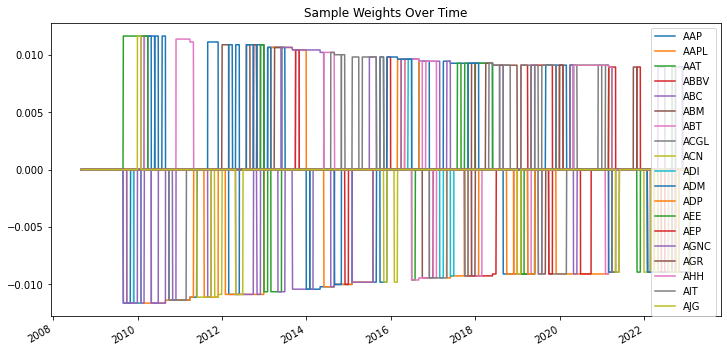

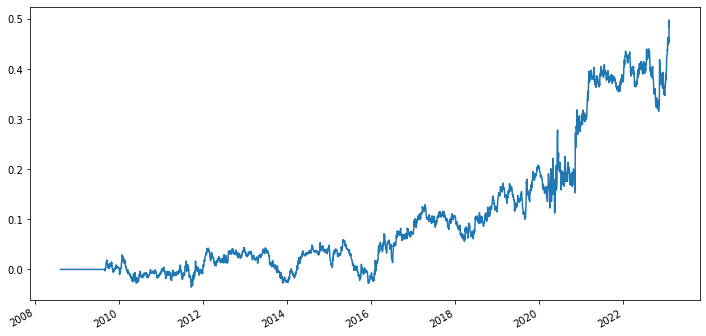

Sharpe Ratio                    0.412141
Drift Adjusted Sharpe Ratio     0.165288
CAGR                            0.027660
Vol                             0.072546
Sortino Ratio                   0.653860
Martin (Ulcer) Ratio            0.000586
Omega Ratio                     0.903196
RR Ratio                        1.085006
Win Rate                        0.480923
Skew                            2.248311
Kurtosis                       39.738080
Max Drawdown                   -0.097853
VaR - Laplace                  -0.017517
CVaR - Laplace                 -0.021737
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['JNJ', 'PEP', 'PG', 'KO', 'KMB', 'CL', 'ED', 'GIS', 'MCD', 'XEL',
       ...
       'Z', 'ABG', 'FBMS', 'TGH', 'TRUP', 'CALX', 'LILAK', 'DT', 'INDI',
       'PRDO'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = 0.0


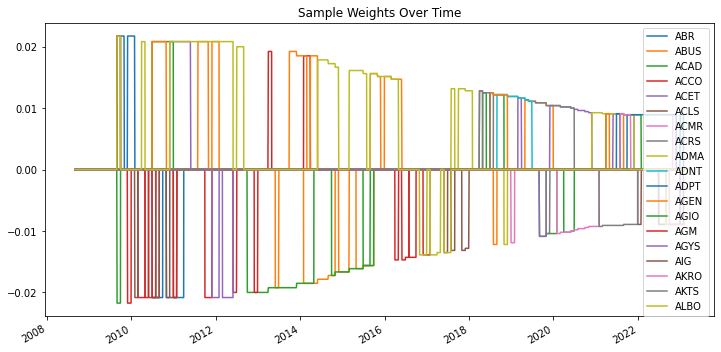

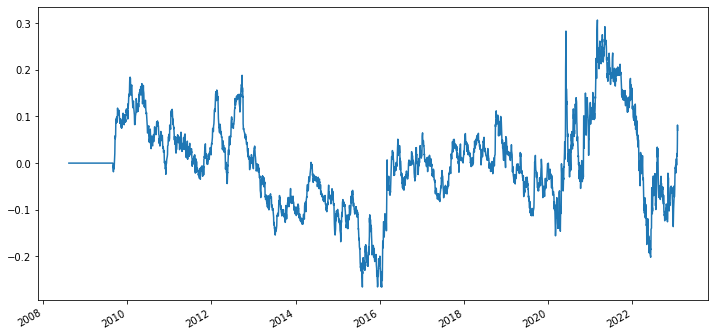

Sharpe Ratio                    0.114315
Drift Adjusted Sharpe Ratio    -0.000297
CAGR                            0.004710
Vol                             0.177017
Sortino Ratio                   0.182556
Martin (Ulcer) Ratio            0.000070
Omega Ratio                     0.951395
RR Ratio                        1.021570
Win Rate                        0.483881
Skew                            1.183536
Kurtosis                       13.837971
Max Drawdown                   -0.388834
VaR - Laplace                  -0.044256
CVaR - Laplace                 -0.055477
dtype: float64


In [28]:
def momentum(returns: pd.DataFrame):
    rolling_cum_rets = np.exp(np.log(1+returns).rolling(window=int(252)).sum() - 1)
    
    # rolling_cum_rets = (rolling_cum_rets - rolling_cum_rets.mean()) / rolling_cum_rets.std()
    rolling_cum_rets = expanding_z_score(factor=rolling_cum_rets)
    
    return rolling_cum_rets

factor_1 = factor_strategy(returns=returns, factor_function=momentum, factor_type='short', rebal_freq='M', rolling_window=20, p=.75, filter_type='high_vol') # Short Low Vol (Large Cap) MoM
print(factor_1.performance_summary)
factor_2= factor_strategy(returns=returns, factor_function=momentum, factor_type='short', rebal_freq='M', rolling_window=20, p=.75, filter_type='low_vol') # Short Low Vol (Large Cap) MoM
print(factor_2.performance_summary)


Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['SRNE', 'BLNK', 'CRGE', 'KRTX', 'BNGO', 'TGTX', 'BLFS', 'VTNR', 'COGT',
       'MARA',
       ...
       'CG', 'MSCI', 'TRST', 'CRI', 'MOFG', 'HCA', 'AIZ', 'VVV', 'GATX',
       'EXR'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = -0.0


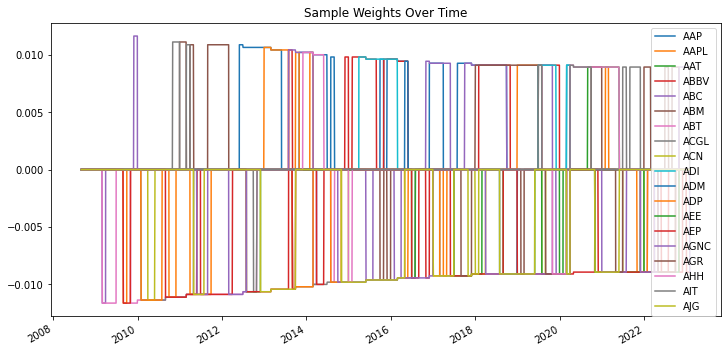

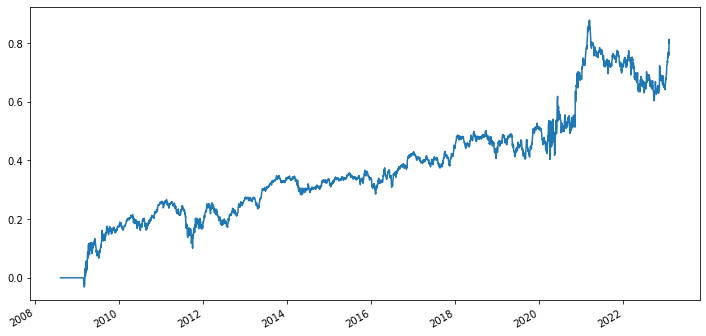

Sharpe Ratio                    0.524613
Drift Adjusted Sharpe Ratio     0.366883
CAGR                            0.041447
Vol                             0.084136
Sortino Ratio                   0.780914
Martin (Ulcer) Ratio            0.000651
Omega Ratio                     0.948172
RR Ratio                        1.105483
Win Rate                        0.507697
Skew                            1.142236
Kurtosis                       18.102372
Max Drawdown                   -0.146440
VaR - Laplace                  -0.020463
CVaR - Laplace                 -0.026131
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['JNJ', 'PEP', 'PG', 'KO', 'KMB', 'CL', 'ED', 'GIS', 'MCD', 'XEL',
       ...
       'Z', 'ABG', 'FBMS', 'TGH', 'TRUP', 'CALX', 'LILAK', 'DT', 'INDI',
       'PRDO'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = 0.0


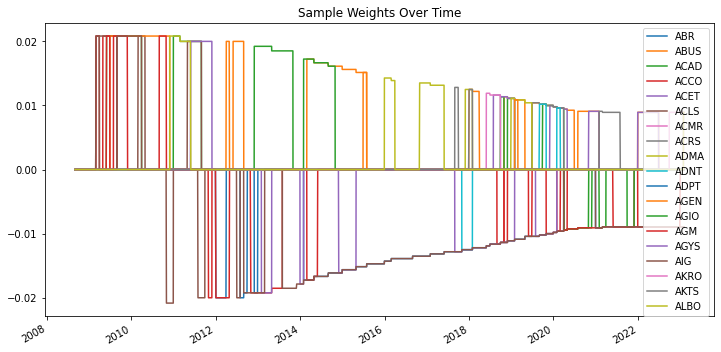

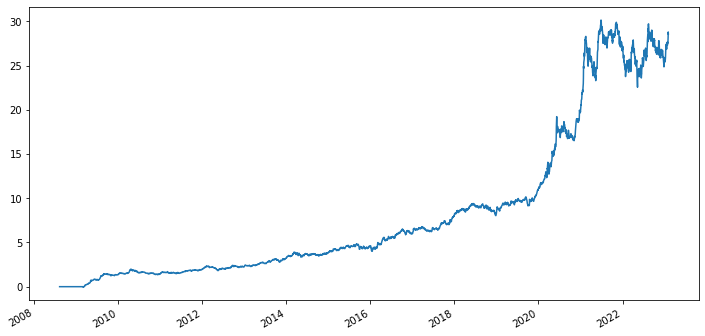

Sharpe Ratio                   1.544444
Drift Adjusted Sharpe Ratio    0.157358
CAGR                           0.263620
Vol                            0.159784
Sortino Ratio                  2.628705
Martin (Ulcer) Ratio           0.002213
Omega Ratio                    1.219771
RR Ratio                       1.315956
Win Rate                       0.526511
Skew                           0.768407
Kurtosis                       7.073322
Max Drawdown                  -0.243877
VaR - Laplace                 -0.038932
CVaR - Laplace                -0.049969
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['SRNE', 'BLNK', 'CRGE', 'KRTX', 'BNGO', 'TGTX', 'BLFS', 'VTNR', 'COGT',
       'MARA',
       ...
       'CG', 'MSCI', 'TRST', 'CRI', 'MOFG', 'HCA', 'AIZ', 'VVV', 'GATX',
       'EXR'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = 0.0


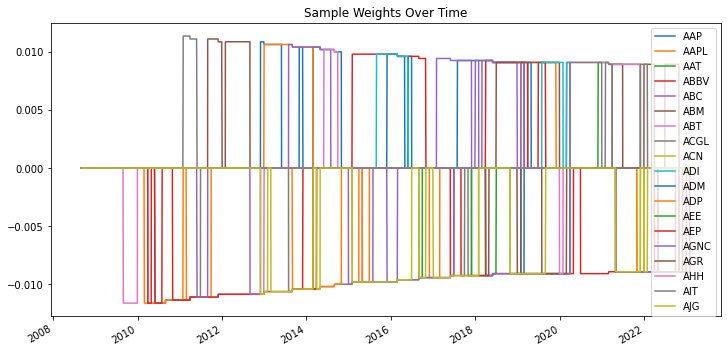

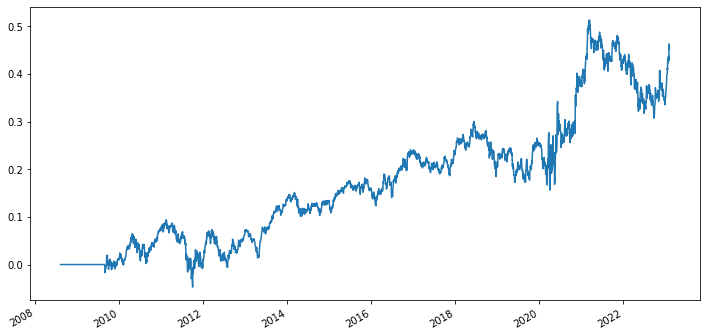

Sharpe Ratio                    0.379299
Drift Adjusted Sharpe Ratio     0.267203
CAGR                            0.026097
Vol                             0.075400
Sortino Ratio                   0.560356
Martin (Ulcer) Ratio            0.000405
Omega Ratio                     0.909034
RR Ratio                        1.072863
Win Rate                        0.508134
Skew                            0.706484
Kurtosis                       11.683261
Max Drawdown                   -0.136138
VaR - Laplace                  -0.018144
CVaR - Laplace                 -0.022987
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['JNJ', 'PEP', 'PG', 'KO', 'KMB', 'CL', 'ED', 'GIS', 'MCD', 'XEL',
       ...
       'Z', 'ABG', 'FBMS', 'TGH', 'TRUP', 'CALX', 'LILAK', 'DT', 'INDI',
       'PRDO'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = -0.0


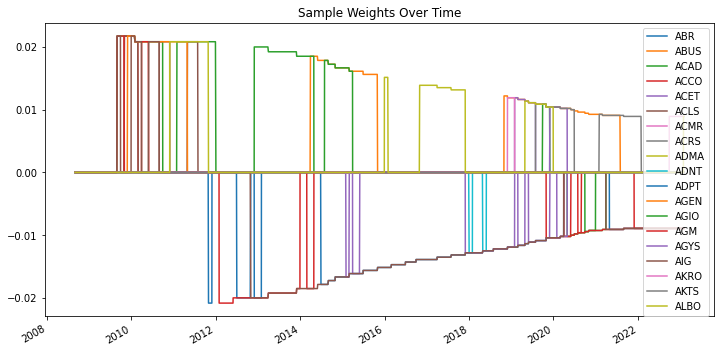

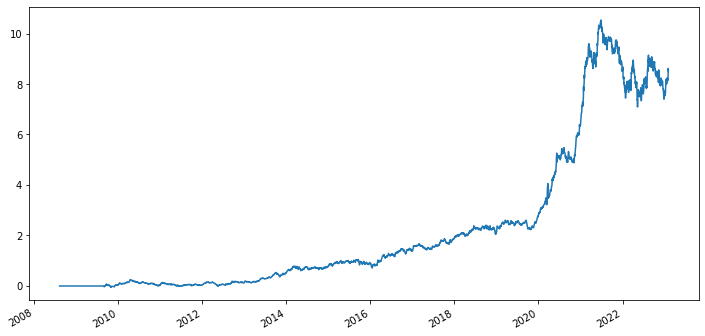

Sharpe Ratio                   1.129962
Drift Adjusted Sharpe Ratio    0.107592
CAGR                           0.168543
Vol                            0.147477
Sortino Ratio                  1.791719
Martin (Ulcer) Ratio           0.001159
Omega Ratio                    1.126365
RR Ratio                       1.222847
Win Rate                       0.520260
Skew                           0.447439
Kurtosis                       6.559916
Max Drawdown                  -0.298723
VaR - Laplace                 -0.034583
CVaR - Laplace                -0.044305
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['SRNE', 'BLNK', 'CRGE', 'KRTX', 'BNGO', 'TGTX', 'BLFS', 'VTNR', 'COGT',
       'MARA',
       ...
       'CG', 'MSCI', 'TRST', 'CRI', 'MOFG', 'HCA', 'AIZ', 'VVV', 'GATX',
       'EXR'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = 0.0


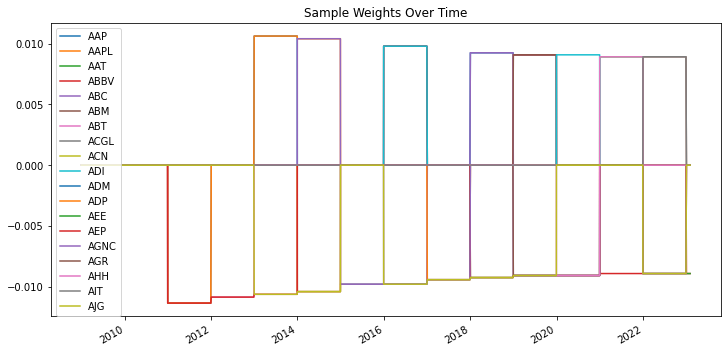

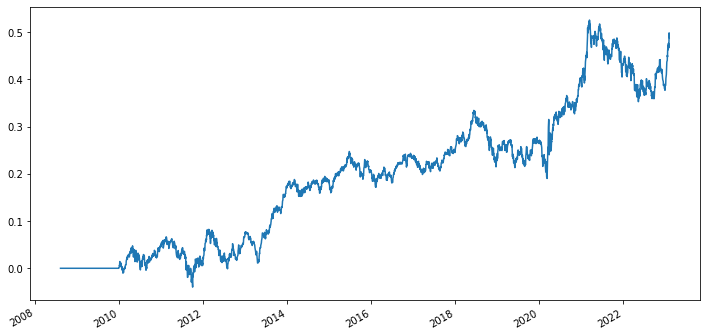

Sharpe Ratio                   0.493793
Drift Adjusted Sharpe Ratio    0.370667
CAGR                           0.027878
Vol                            0.059237
Sortino Ratio                  0.742410
Martin (Ulcer) Ratio           0.000471
Omega Ratio                    0.892797
RR Ratio                       1.091237
Win Rate                       0.505765
Skew                           0.215435
Kurtosis                       5.313723
Max Drawdown                  -0.113336
VaR - Laplace                 -0.014098
CVaR - Laplace                -0.017506
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['JNJ', 'PEP', 'PG', 'KO', 'KMB', 'CL', 'ED', 'GIS', 'MCD', 'XEL',
       ...
       'Z', 'ABG', 'FBMS', 'TGH', 'TRUP', 'CALX', 'LILAK', 'DT', 'INDI',
       'PRDO'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = -0.0


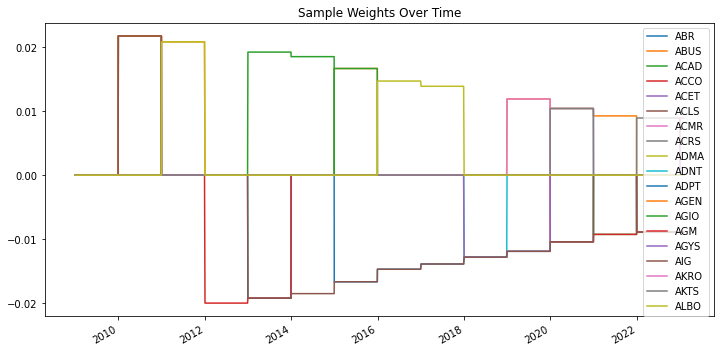

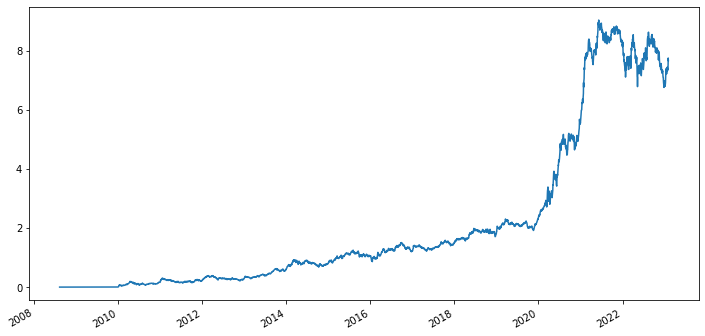

Sharpe Ratio                   1.124090
Drift Adjusted Sharpe Ratio    0.106613
CAGR                           0.160936
Vol                            0.141704
Sortino Ratio                  1.682951
Martin (Ulcer) Ratio           0.001598
Omega Ratio                    1.124580
RR Ratio                       1.227730
Win Rate                       0.525789
Skew                           0.268893
Kurtosis                       7.386925
Max Drawdown                  -0.227163
VaR - Laplace                 -0.034786
CVaR - Laplace                -0.043745
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['SRNE', 'BLNK', 'CRGE', 'KRTX', 'BNGO', 'TGTX', 'BLFS', 'VTNR', 'COGT',
       'MARA',
       ...
       'CG', 'MSCI', 'TRST', 'CRI', 'MOFG', 'HCA', 'AIZ', 'VVV', 'GATX',
       'EXR'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = 0.0


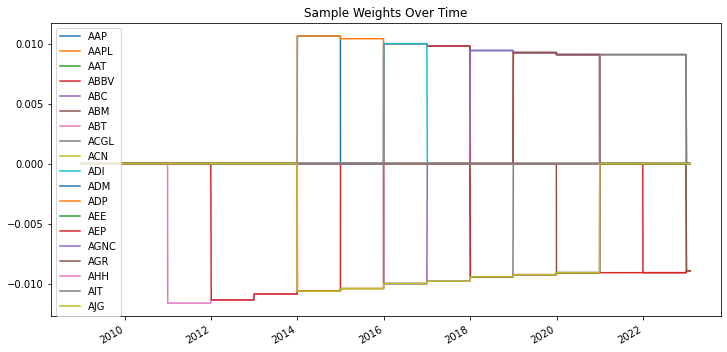

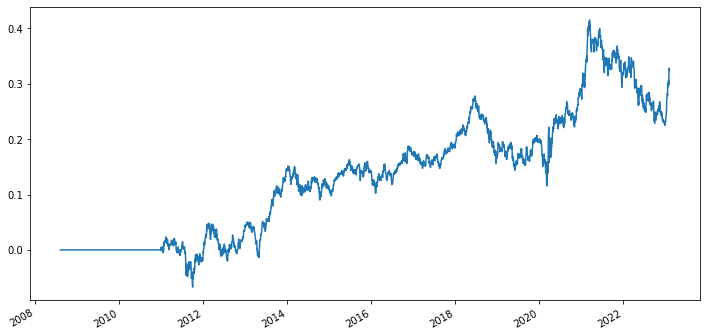

Sharpe Ratio                   0.368825
Drift Adjusted Sharpe Ratio    0.301790
CAGR                           0.019635
Vol                            0.057146
Sortino Ratio                  0.532661
Martin (Ulcer) Ratio           0.000304
Omega Ratio                    0.861623
RR Ratio                       1.071074
Win Rate                       0.502957
Skew                           0.271488
Kurtosis                       7.106228
Max Drawdown                  -0.134406
VaR - Laplace                 -0.014122
CVaR - Laplace                -0.017768
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['JNJ', 'PEP', 'PG', 'KO', 'KMB', 'CL', 'ED', 'GIS', 'MCD', 'XEL',
       ...
       'Z', 'ABG', 'FBMS', 'TGH', 'TRUP', 'CALX', 'LILAK', 'DT', 'INDI',
       'PRDO'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = 0.0


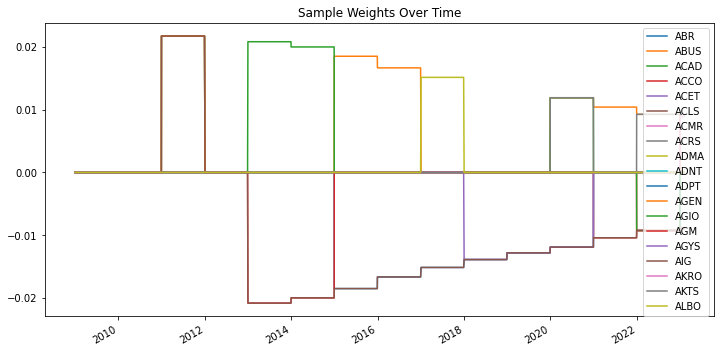

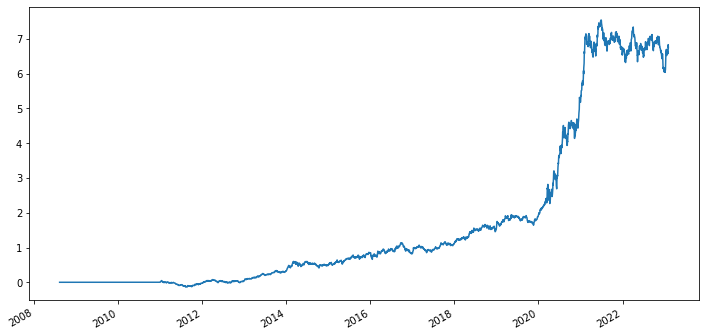

Sharpe Ratio                   1.120001
Drift Adjusted Sharpe Ratio    0.115863
CAGR                           0.151987
Vol                            0.134414
Sortino Ratio                  1.635472
Martin (Ulcer) Ratio           0.001730
Omega Ratio                    1.123861
RR Ratio                       1.238740
Win Rate                       0.525624
Skew                           0.255614
Kurtosis                       8.572094
Max Drawdown                  -0.179613
VaR - Laplace                 -0.032166
CVaR - Laplace                -0.039894
dtype: float64


In [29]:
factor_data = {}
def momentum(returns: pd.DataFrame):
    rolling_cum_rets = np.exp(np.log(1+returns).rolling(window=int(252)).sum() - 1)
    
    # rolling_cum_rets = (rolling_cum_rets - rolling_cum_rets.mean()) / rolling_cum_rets.std()
    rolling_cum_rets = expanding_z_score(factor=rolling_cum_rets)
    
    return rolling_cum_rets

factor_1 = factor_strategy(returns=returns, factor_function=momentum, factor_type='short', rebal_freq='M', rolling_window=20, p=.75, filter_type='high_vol') # Short Low Vol (Large Cap) MoM
print(factor_1.performance_summary)

factor_2= factor_strategy(returns=returns, factor_function=momentum, factor_type='short', rebal_freq='M', rolling_window=20, p=.75, filter_type='low_vol') # Short Low Vol (Large Cap) MoM
print(factor_2.performance_summary)

def vol_mom_factor(returns):
    vol_mom_factor = returns.rolling(window=int(252/2)).std()*252**.5
    # vol_mom_factor = (vol_mom_factor - vol_mom_factor.mean()) / vol_mom_factor.std()
    vol_mom_factor = expanding_z_score(factor=vol_mom_factor)
    return vol_mom_factor

factor_3 = factor_strategy(returns=returns, factor_function=vol_mom_factor, factor_type='long', rebal_freq='M', rolling_window=20, p=.75, filter_type='high_vol')
print(factor_3.performance_summary)


factor_4 = factor_strategy(returns=returns, factor_function=vol_mom_factor, factor_type='long', rebal_freq='M', rolling_window=20, p=.75, filter_type='low_vol')
print(factor_4.performance_summary)


def vol_mom_factor(returns):
    vol_mom_factor = returns.rolling(window=int(252)).std()*252**.5
    vol_mom_factor = expanding_z_score(factor=vol_mom_factor)
    return vol_mom_factor

factor_5 = factor_strategy(returns=returns, factor_function=vol_mom_factor, factor_type='long', rebal_freq='M', rolling_window=20, p=.75, filter_type='high_vol')
print(factor_5.performance_summary)

factor_6 = factor_strategy(returns=returns, factor_function=vol_mom_factor, factor_type='long', rebal_freq='M', rolling_window=20, p=.75, filter_type='low_vol')
print(factor_6.performance_summary)

def vol_mom_factor(returns):
    vol_mom_factor = returns.rolling(window=int(252)).std()*252**.5
    vol_mom_factor = expanding_z_score(factor=vol_mom_factor)
    return vol_mom_factor

factor_7 = factor_strategy(returns=returns, factor_function=vol_mom_factor, factor_type='long', rebal_freq='A', rolling_window=20, p=.75, filter_type='high_vol')
print(factor_7.performance_summary)
factor_8 = factor_strategy(returns=returns, factor_function=vol_mom_factor, factor_type='long', rebal_freq='A', rolling_window=20, p=.75, filter_type='low_vol')
print(factor_8.performance_summary)

def vol_mom_factor(returns):
    vol_mom_factor = returns.rolling(window=int(252*2)).std()*252**.5
    vol_mom_factor = expanding_z_score(factor=vol_mom_factor)
    return vol_mom_factor

factor_9 = factor_strategy(returns=returns, factor_function=vol_mom_factor, factor_type='long', rebal_freq='A', rolling_window=20, p=.75, filter_type='high_vol')
print(factor_9.performance_summary)
factor_10 = factor_strategy(returns=returns, factor_function=vol_mom_factor, factor_type='long', rebal_freq='A', rolling_window=20, p=.75, filter_type='low_vol')
print(factor_10.performance_summary)

In [57]:
factor_data = {}
factor_data['Factor 1'] = factor_1.performance_summary.loc['Sharpe Ratio']
factor_data['Factor 2'] = factor_2.performance_summary.loc['Sharpe Ratio']
factor_data['Factor 3'] = factor_3.performance_summary.loc['Sharpe Ratio']
factor_data['Factor 4'] = factor_4.performance_summary.loc['Sharpe Ratio']
factor_data['Factor 5'] = factor_5.performance_summary.loc['Sharpe Ratio']
factor_data['Factor 6'] = factor_6.performance_summary.loc['Sharpe Ratio']
factor_data['Factor 7'] = factor_7.performance_summary.loc['Sharpe Ratio']
factor_data['Factor 8'] = factor_8.performance_summary.loc['Sharpe Ratio']
factor_data['Factor 9'] = factor_9.performance_summary.loc['Sharpe Ratio']
factor_data['Factor 10'] = factor_10.performance_summary.loc['Sharpe Ratio']

# Get Non-Implementable Factors

Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['SRNE', 'BLNK', 'CRGE', 'KRTX', 'BNGO', 'TGTX', 'BLFS', 'VTNR', 'COGT',
       'MARA',
       ...
       'CG', 'MSCI', 'TRST', 'CRI', 'MOFG', 'HCA', 'AIZ', 'VVV', 'GATX',
       'EXR'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = -0.0


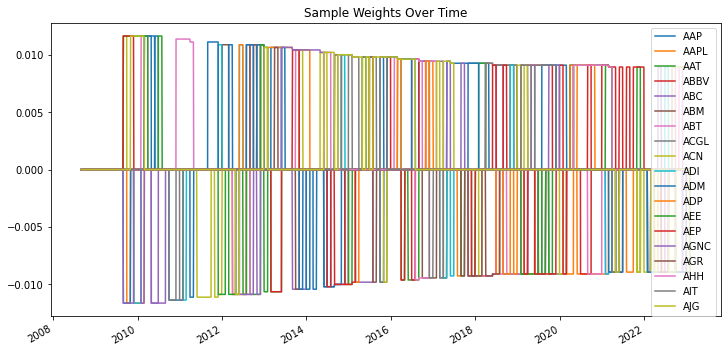

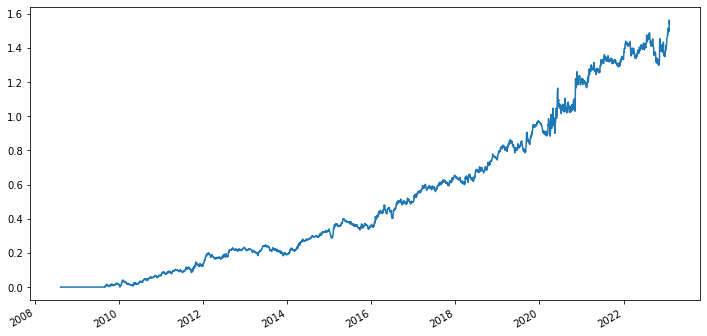

Sharpe Ratio                    1.010785
Drift Adjusted Sharpe Ratio     0.741245
CAGR                            0.066605
Vol                             0.065938
Sortino Ratio                   1.644510
Martin (Ulcer) Ratio            0.002104
Omega Ratio                     0.997035
RR Ratio                        1.217506
Win Rate                        0.509021
Skew                            2.197247
Kurtosis                       36.765116
Max Drawdown                   -0.076609
VaR - Laplace                  -0.015527
CVaR - Laplace                 -0.019372
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['JNJ', 'PEP', 'PG', 'KO', 'KMB', 'CL', 'ED', 'GIS', 'MCD', 'XEL',
       ...
       'Z', 'ABG', 'FBMS', 'TGH', 'TRUP', 'CALX', 'LILAK', 'DT', 'INDI',
       'PRDO'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = 0.0


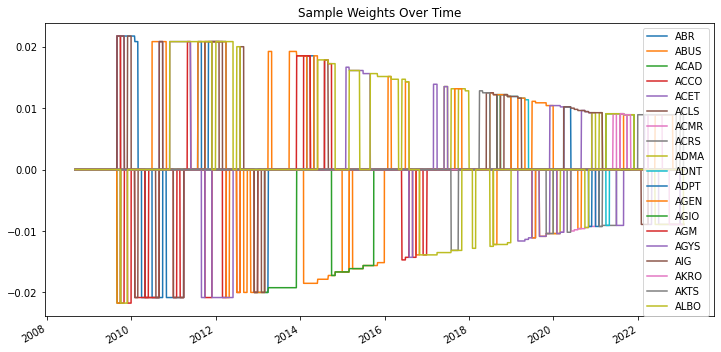

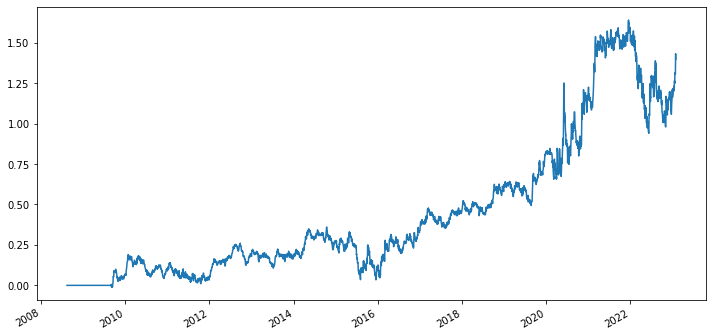

Sharpe Ratio                    0.467006
Drift Adjusted Sharpe Ratio     0.137286
CAGR                            0.062229
Vol                             0.154717
Sortino Ratio                   0.742510
Martin (Ulcer) Ratio            0.000539
Omega Ratio                     1.005513
RR Ratio                        1.090898
Win Rate                        0.493937
Skew                            1.185322
Kurtosis                       14.444635
Max Drawdown                   -0.265112
VaR - Laplace                  -0.036786
CVaR - Laplace                 -0.047670
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['SRNE', 'BLNK', 'CRGE', 'KRTX', 'BNGO', 'TGTX', 'BLFS', 'VTNR', 'COGT',
       'MARA',
       ...
       'CG', 'MSCI', 'TRST', 'CRI', 'MOFG', 'HCA', 'AIZ', 'VVV', 'GATX',
       'EXR'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = -0.0


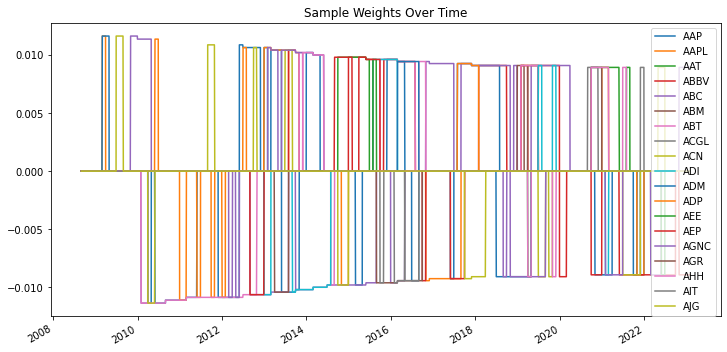

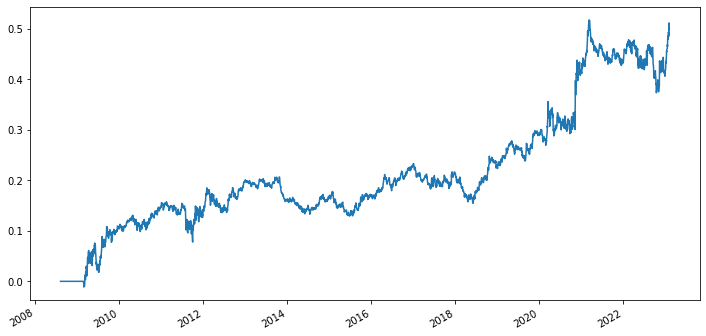

Sharpe Ratio                    0.528328
Drift Adjusted Sharpe Ratio     0.254543
CAGR                            0.028313
Vol                             0.055778
Sortino Ratio                   0.796737
Martin (Ulcer) Ratio            0.000605
Omega Ratio                     0.877036
RR Ratio                        1.107322
Win Rate                        0.504276
Skew                            1.952596
Kurtosis                       39.829065
Max Drawdown                   -0.094984
VaR - Laplace                  -0.013309
CVaR - Laplace                 -0.017275
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['JNJ', 'PEP', 'PG', 'KO', 'KMB', 'CL', 'ED', 'GIS', 'MCD', 'XEL',
       ...
       'Z', 'ABG', 'FBMS', 'TGH', 'TRUP', 'CALX', 'LILAK', 'DT', 'INDI',
       'PRDO'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = 0.0


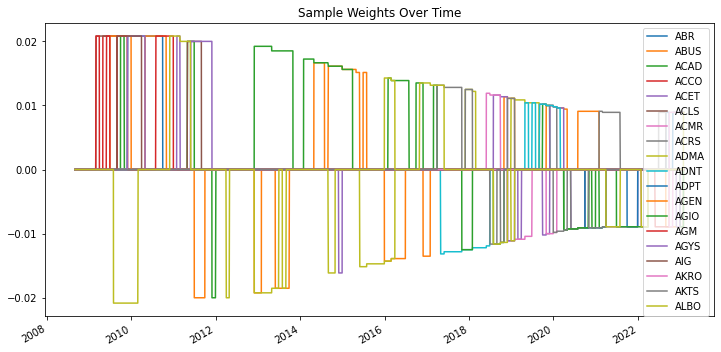

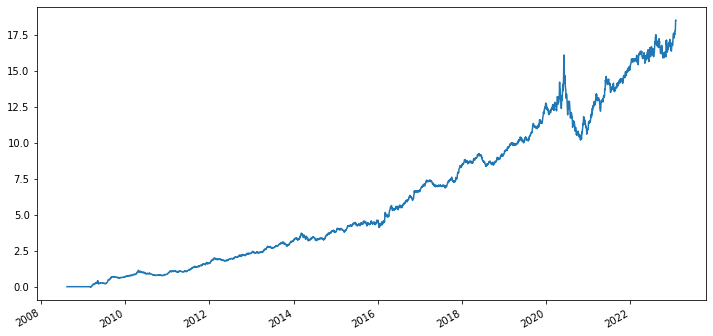

Sharpe Ratio                    1.574102
Drift Adjusted Sharpe Ratio     0.821060
CAGR                            0.227722
Vol                             0.136310
Sortino Ratio                   2.223214
Martin (Ulcer) Ratio            0.001675
Omega Ratio                     1.218286
RR Ratio                        1.335489
Win Rate                        0.534778
Skew                           -0.635959
Kurtosis                       22.686411
Max Drawdown                   -0.345939
VaR - Laplace                  -0.033031
CVaR - Laplace                 -0.041202
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['SRNE', 'BLNK', 'CRGE', 'KRTX', 'BNGO', 'TGTX', 'BLFS', 'VTNR', 'COGT',
       'MARA',
       ...
       'CG', 'MSCI', 'TRST', 'CRI', 'MOFG', 'HCA', 'AIZ', 'VVV', 'GATX',
       'EXR'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = 0.0


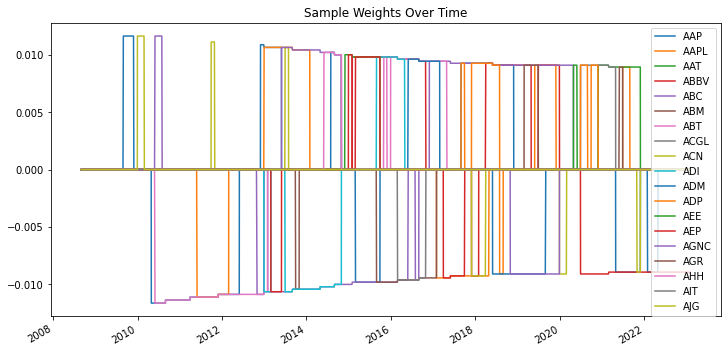

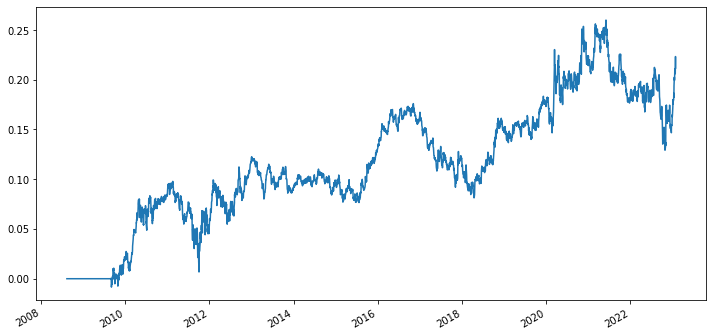

Sharpe Ratio                   0.313888
Drift Adjusted Sharpe Ratio    0.257749
CAGR                           0.013356
Vol                            0.045574
Sortino Ratio                  0.472111
Martin (Ulcer) Ratio           0.000278
Omega Ratio                    0.810539
RR Ratio                       1.058593
Win Rate                       0.503697
Skew                           0.569298
Kurtosis                       8.820931
Max Drawdown                  -0.103655
VaR - Laplace                 -0.011215
CVaR - Laplace                -0.014685
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['JNJ', 'PEP', 'PG', 'KO', 'KMB', 'CL', 'ED', 'GIS', 'MCD', 'XEL',
       ...
       'Z', 'ABG', 'FBMS', 'TGH', 'TRUP', 'CALX', 'LILAK', 'DT', 'INDI',
       'PRDO'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = 0.0


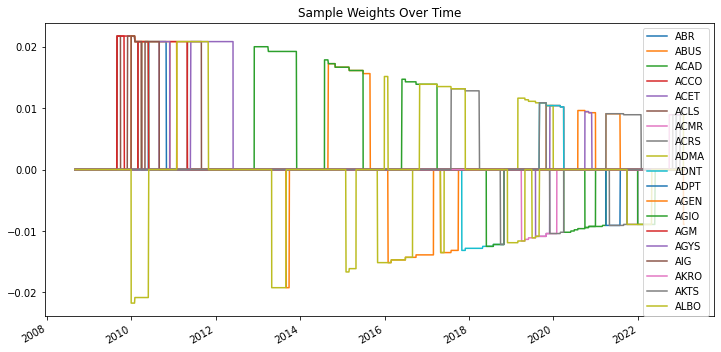

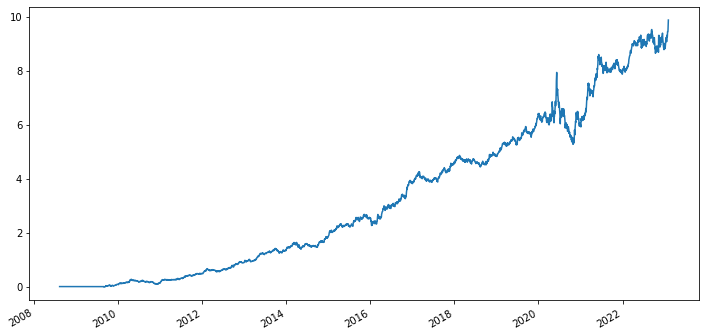

Sharpe Ratio                   1.457567
Drift Adjusted Sharpe Ratio    0.720393
CAGR                           0.179334
Vol                            0.117963
Sortino Ratio                  2.296258
Martin (Ulcer) Ratio           0.001898
Omega Ratio                    1.170116
RR Ratio                       1.297550
Win Rate                       0.526471
Skew                           0.524432
Kurtosis                       7.904582
Max Drawdown                  -0.298228
VaR - Laplace                 -0.027936
CVaR - Laplace                -0.035912
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['SRNE', 'BLNK', 'CRGE', 'KRTX', 'BNGO', 'TGTX', 'BLFS', 'VTNR', 'COGT',
       'MARA',
       ...
       'CG', 'MSCI', 'TRST', 'CRI', 'MOFG', 'HCA', 'AIZ', 'VVV', 'GATX',
       'EXR'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = 0.0


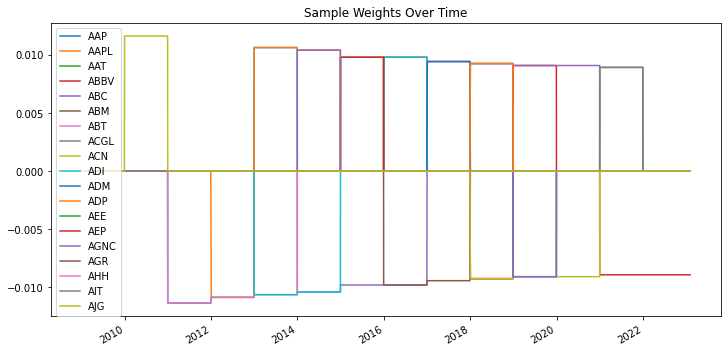

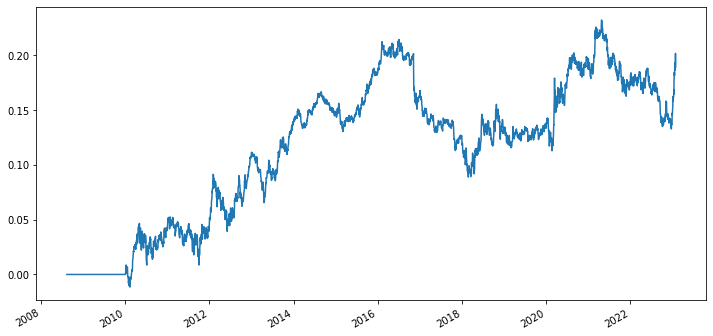

Sharpe Ratio                   0.343974
Drift Adjusted Sharpe Ratio    0.121524
CAGR                           0.012053
Vol                            0.036799
Sortino Ratio                  0.510170
Martin (Ulcer) Ratio           0.000199
Omega Ratio                    0.768576
RR Ratio                       1.063639
Win Rate                       0.500303
Skew                           0.225158
Kurtosis                       5.510465
Max Drawdown                  -0.103317
VaR - Laplace                 -0.009056
CVaR - Laplace                -0.011435
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['JNJ', 'PEP', 'PG', 'KO', 'KMB', 'CL', 'ED', 'GIS', 'MCD', 'XEL',
       ...
       'Z', 'ABG', 'FBMS', 'TGH', 'TRUP', 'CALX', 'LILAK', 'DT', 'INDI',
       'PRDO'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = 0.0


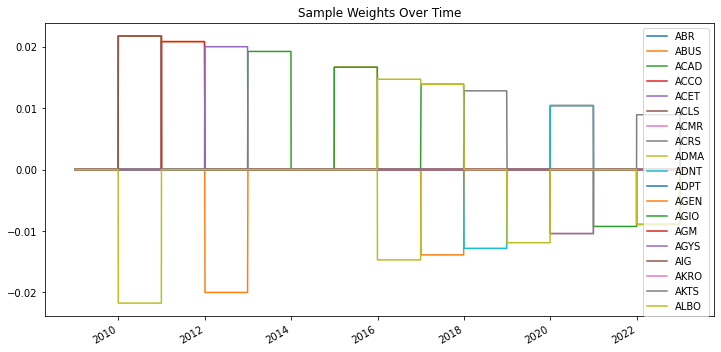

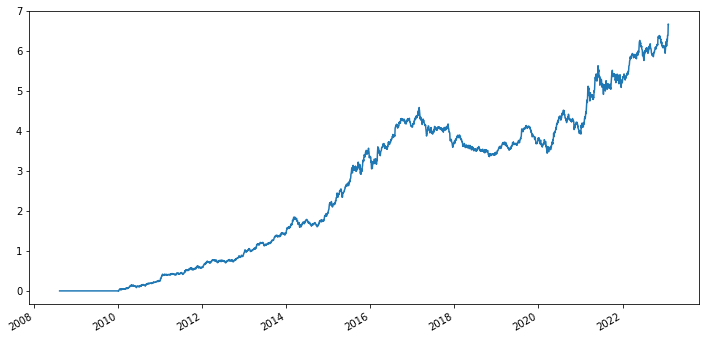

Sharpe Ratio                   1.451328
Drift Adjusted Sharpe Ratio    0.581321
CAGR                           0.151081
Vol                            0.100445
Sortino Ratio                  2.219569
Martin (Ulcer) Ratio           0.001191
Omega Ratio                    1.145447
RR Ratio                       1.290797
Win Rate                       0.532464
Skew                           0.162551
Kurtosis                       4.789813
Max Drawdown                  -0.219902
VaR - Laplace                 -0.023551
CVaR - Laplace                -0.030090
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['SRNE', 'BLNK', 'CRGE', 'KRTX', 'BNGO', 'TGTX', 'BLFS', 'VTNR', 'COGT',
       'MARA',
       ...
       'CG', 'MSCI', 'TRST', 'CRI', 'MOFG', 'HCA', 'AIZ', 'VVV', 'GATX',
       'EXR'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = -0.0


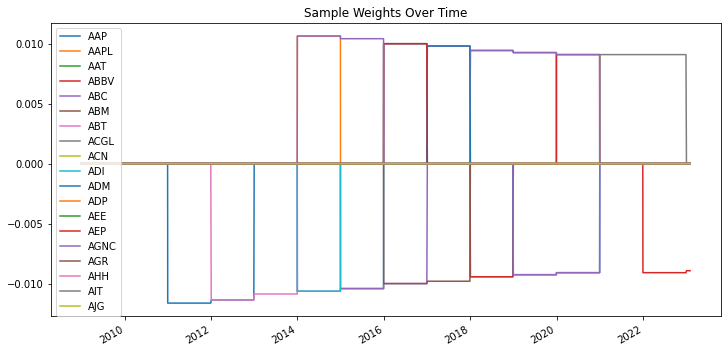

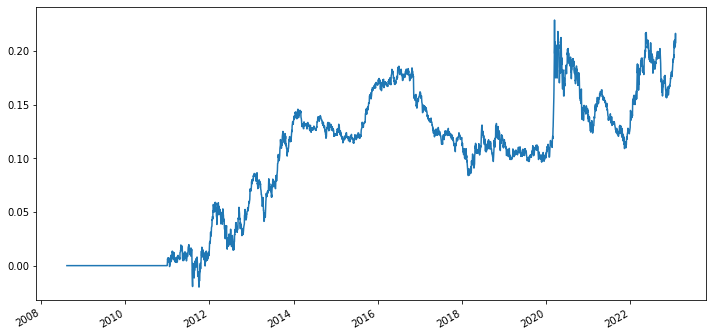

Sharpe Ratio                    0.345572
Drift Adjusted Sharpe Ratio     0.147544
CAGR                            0.013133
Vol                             0.040081
Sortino Ratio                   0.465431
Martin (Ulcer) Ratio            0.000218
Omega Ratio                     0.769312
RR Ratio                        1.071951
Win Rate                        0.510512
Skew                            0.004195
Kurtosis                       14.646636
Max Drawdown                   -0.097442
VaR - Laplace                  -0.010062
CVaR - Laplace                 -0.012052
dtype: float64
Dropped tickers: Index(['PRTA', 'AMEH', 'AMEH', 'AMPY', 'CHRD'], dtype='object')
Dropped tickers: Index(['JNJ', 'PEP', 'PG', 'KO', 'KMB', 'CL', 'ED', 'GIS', 'MCD', 'XEL',
       ...
       'Z', 'ABG', 'FBMS', 'TGH', 'TRUP', 'CALX', 'LILAK', 'DT', 'INDI',
       'PRDO'],
      dtype='object', length=1689)
Weights SUM: Market Neutral = -0.0


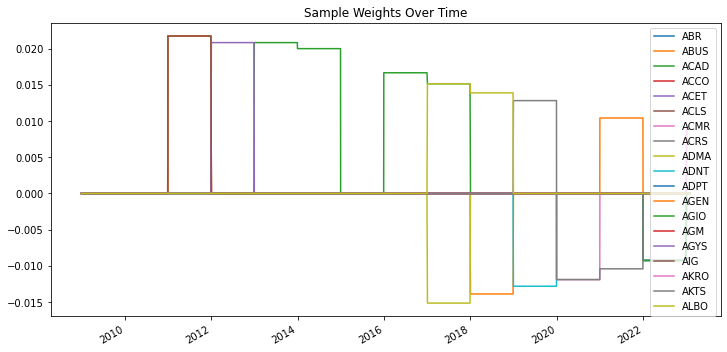

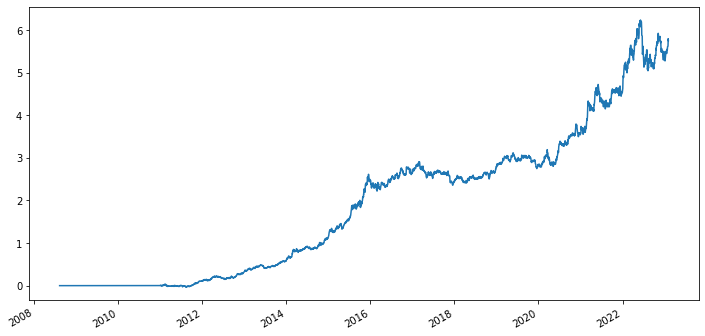

Sharpe Ratio                   1.334133
Drift Adjusted Sharpe Ratio    0.471239
CAGR                           0.141090
Vol                            0.102922
Sortino Ratio                  1.918037
Martin (Ulcer) Ratio           0.001806
Omega Ratio                    1.130548
RR Ratio                       1.277115
Win Rate                       0.535151
Skew                           0.013938
Kurtosis                       5.580249
Max Drawdown                  -0.164468
VaR - Laplace                 -0.024756
CVaR - Laplace                -0.031254
dtype: float64


In [7]:
def momentum(returns: pd.DataFrame):
    rolling_cum_rets = np.exp(np.log(1+returns).rolling(window=int(252)).sum() - 1)
    
    rolling_cum_rets = (rolling_cum_rets - rolling_cum_rets.mean()) / rolling_cum_rets.std()
    # rolling_cum_rets = expanding_z_score(factor=rolling_cum_rets)
    
    return rolling_cum_rets

factor_1_fake = factor_strategy(returns=returns, factor_function=momentum, factor_type='short', rebal_freq='M', rolling_window=20, p=.75, filter_type='high_vol') # Short Low Vol (Large Cap) MoM
print(factor_1_fake.performance_summary)

factor_2_fake= factor_strategy(returns=returns, factor_function=momentum, factor_type='short', rebal_freq='M', rolling_window=20, p=.75, filter_type='low_vol') # Short Low Vol (Large Cap) MoM
print(factor_2_fake.performance_summary)

def vol_mom_factor(returns):
    vol_mom_factor = returns.rolling(window=int(252/2)).std()*252**.5
    vol_mom_factor = (vol_mom_factor - vol_mom_factor.mean()) / vol_mom_factor.std()
    # vol_mom_factor = expanding_z_score(factor=vol_mom_factor)
    return vol_mom_factor

factor_3_fake = factor_strategy(returns=returns, factor_function=vol_mom_factor, factor_type='long', rebal_freq='M', rolling_window=20, p=.75, filter_type='high_vol')
print(factor_3_fake.performance_summary)


factor_4_fake = factor_strategy(returns=returns, factor_function=vol_mom_factor, factor_type='long', rebal_freq='M', rolling_window=20, p=.75, filter_type='low_vol')
print(factor_4_fake.performance_summary)


def vol_mom_factor(returns):
    vol_mom_factor = returns.rolling(window=int(252)).std()*252**.5
    vol_mom_factor = (vol_mom_factor - vol_mom_factor.mean()) / vol_mom_factor.std()
    # vol_mom_factor = expanding_z_score(factor=vol_mom_factor)
    return vol_mom_factor

factor_5_fake = factor_strategy(returns=returns, factor_function=vol_mom_factor, factor_type='long', rebal_freq='M', rolling_window=20, p=.75, filter_type='high_vol')
print(factor_5_fake.performance_summary)

factor_6_fake = factor_strategy(returns=returns, factor_function=vol_mom_factor, factor_type='long', rebal_freq='M', rolling_window=20, p=.75, filter_type='low_vol')
print(factor_6_fake.performance_summary)

def vol_mom_factor(returns):
    vol_mom_factor = returns.rolling(window=int(252)).std()*252**.5
    vol_mom_factor = (vol_mom_factor - vol_mom_factor.mean()) / vol_mom_factor.std()
    # vol_mom_factor = expanding_z_score(factor=vol_mom_factor)
    return vol_mom_factor

factor_7_fake = factor_strategy(returns=returns, factor_function=vol_mom_factor, factor_type='long', rebal_freq='A', rolling_window=20, p=.75, filter_type='high_vol')
print(factor_7_fake.performance_summary)
factor_8_fake = factor_strategy(returns=returns, factor_function=vol_mom_factor, factor_type='long', rebal_freq='A', rolling_window=20, p=.75, filter_type='low_vol')
print(factor_8_fake.performance_summary)

def vol_mom_factor(returns):
    vol_mom_factor = returns.rolling(window=int(252*2)).std()*252**.5
    vol_mom_factor = (vol_mom_factor - vol_mom_factor.mean()) / vol_mom_factor.std()
    # vol_mom_factor = expanding_z_score(factor=vol_mom_factor)
    return vol_mom_factor

factor_9_fake = factor_strategy(returns=returns, factor_function=vol_mom_factor, factor_type='long', rebal_freq='A', rolling_window=20, p=.75, filter_type='high_vol')
print(factor_9_fake.performance_summary)
factor_10_fake = factor_strategy(returns=returns, factor_function=vol_mom_factor, factor_type='long', rebal_freq='A', rolling_window=20, p=.75, filter_type='low_vol')
print(factor_10_fake.performance_summary)

In [11]:
factor_returns = {}
factor_returns['Factor 1'] = factor_1_fake.factor_returns
factor_returns['Factor 2'] = factor_2_fake.factor_returns
factor_returns['Factor 3'] = factor_3_fake.factor_returns
factor_returns['Factor 4'] = factor_4_fake.factor_returns
factor_returns['Factor 5'] = factor_5_fake.factor_returns
factor_returns['Factor 6'] = factor_6_fake.factor_returns
factor_returns['Factor 7'] = factor_7_fake.factor_returns
factor_returns['Factor 8'] = factor_8_fake.factor_returns
factor_returns['Factor 9'] = factor_9_fake.factor_returns
factor_returns['Factor 10'] = factor_10_fake.factor_returns

factor_returns = pd.DataFrame(factor_returns)

Plot Factor Sharpe Ratios

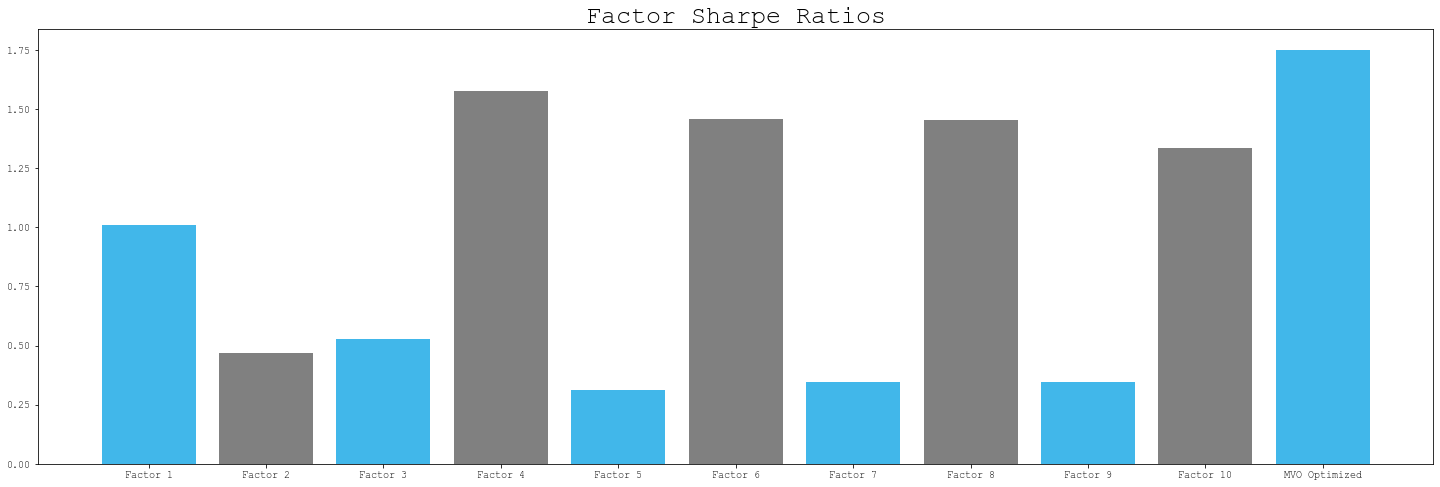

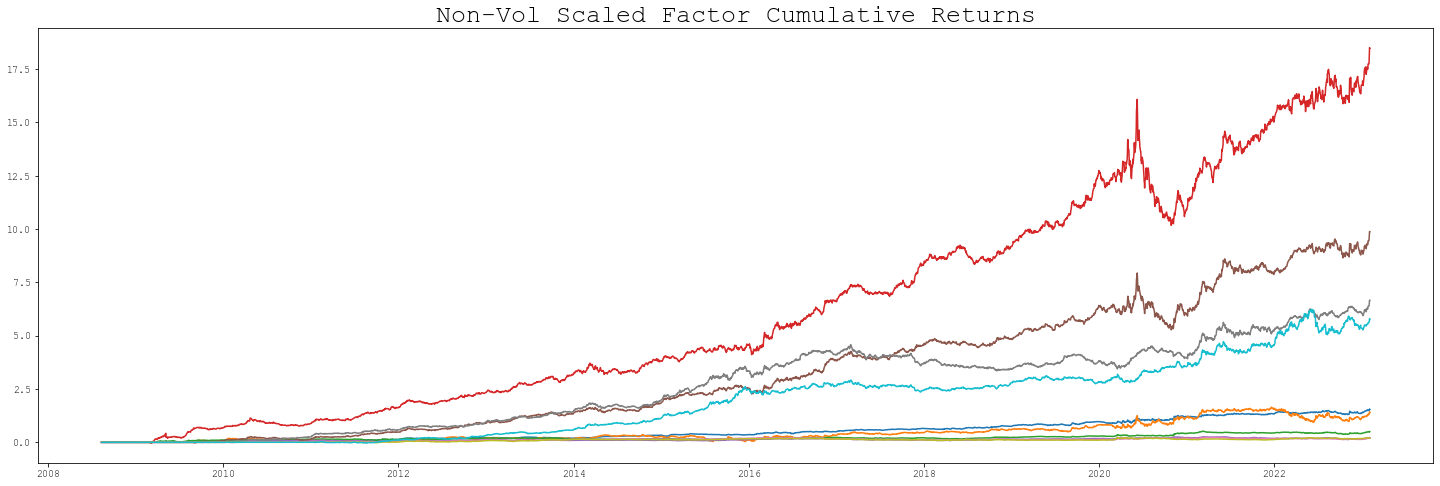

In [65]:
tamid_color = '#41B7EA'
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Courier New'

plt.figure(figsize=(25, 8))
plt.title("Factor Sharpe Ratios", size=25)


j = 0
for i, val in factor_data_non_implemntable.items():
    if j%2 == 0:
        plt.bar(i, height=val, color=tamid_color)
    else:
        plt.bar(i, height=val, color='Grey')
    j += 1

plt.figure(figsize=(25, 8))
plt.title('Non-Vol Scaled Factor Cumulative Returns', size=25)
plt.plot(backtest_tools.cumulative_returns(factor_returns))

In [57]:
factor_data_non_implemntable = {}
factor_data_non_implemntable['Factor 1'] = factor_1_fake.performance_summary.loc[['Sharpe Ratio', 'Drift Adjusted Sharpe Ratio']]
factor_data_non_implemntable['Factor 2'] = factor_2_fake.performance_summary.loc[['Sharpe Ratio', 'Drift Adjusted Sharpe Ratio']]
factor_data_non_implemntable['Factor 3'] = factor_3_fake.performance_summary.loc[['Sharpe Ratio', 'Drift Adjusted Sharpe Ratio']]
factor_data_non_implemntable['Factor 4'] = factor_4_fake.performance_summary.loc[['Sharpe Ratio', 'Drift Adjusted Sharpe Ratio']]
factor_data_non_implemntable['Factor 5'] = factor_5_fake.performance_summary.loc[['Sharpe Ratio', 'Drift Adjusted Sharpe Ratio']]
factor_data_non_implemntable['Factor 6'] = factor_6_fake.performance_summary.loc[['Sharpe Ratio', 'Drift Adjusted Sharpe Ratio']]
factor_data_non_implemntable['Factor 7'] = factor_7_fake.performance_summary.loc[['Sharpe Ratio', 'Drift Adjusted Sharpe Ratio']]
factor_data_non_implemntable['Factor 8'] = factor_8_fake.performance_summary.loc[['Sharpe Ratio', 'Drift Adjusted Sharpe Ratio']]
factor_data_non_implemntable['Factor 9'] = factor_9_fake.performance_summary.loc[['Sharpe Ratio', 'Drift Adjusted Sharpe Ratio']]
factor_data_non_implemntable['Factor 10'] = factor_10_fake.performance_summary.loc[['Sharpe Ratio', 'Drift Adjusted Sharpe Ratio']]

In [58]:
factor_data_non_implemntable = pd.DataFrame(factor_data_non_implemntable)
factor_data_non_implemntable

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10
Sharpe Ratio,1.010785,0.467006,0.528328,1.574102,0.313888,1.457567,0.343974,1.451328,0.345572,1.334133
Drift Adjusted Sharpe Ratio,0.741245,0.137286,0.254543,0.821060,0.257749,0.720393,0.121524,0.581321,0.147544,0.471239


In [61]:
factor_data_non_implemntable.to_clipboard()

Optimize Portfolio of Factors - Implementable

In [68]:
factor_returns.corr().to_clipboard()

C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\backtest_tools\portfolio_tools.py:31: RuntimeWarning: invalid value encountered in double_scalars
  sharpe_ratio = mu / sigma * 252 ** .5
C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\scipy\optimize\optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


Factor 1     0.2
Factor 2     0.2
Factor 3     0.2
Factor 4     0.2
Factor 5     0.2
Factor 6     0.2
Factor 7     0.2
Factor 8     0.2
Factor 9     0.2
Factor 10    0.2
Name: 2023-02-03 00:00:00, dtype: float64


Sharpe Ratio                    1.750599
Drift Adjusted Sharpe Ratio     0.590028
CAGR                            0.173221
Vol                             0.093785
Sortino Ratio                   2.849259
Martin (Ulcer) Ratio            0.003259
Omega Ratio                     1.207754
RR Ratio                        1.381096
Win Rate                        0.533352
Skew                            1.050947
Kurtosis                       13.420996
Max Drawdown                   -0.160457
VaR - Laplace                  -0.022484
CVaR - Laplace                 -0.027962
dtype: float64

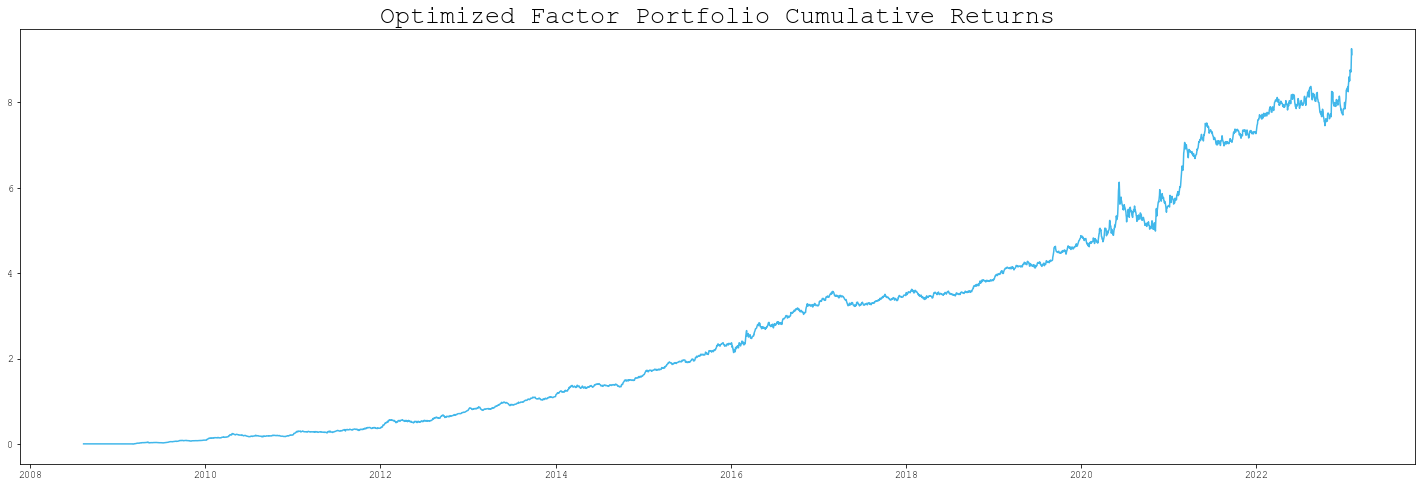

In [66]:
# tmp_rets = pd.concat([factor_2.factor_returns, factor_1.factor_returns, factor_3.factor_returns, 
#                       factor_4.factor_returns, factor_5.factor_returns, factor_6.factor_returns, 
#                       factor_7.factor_returns, factor_8.factor_returns, factor_8.factor_returns, 
#                       factor_9.factor_returns, factor_10.factor_returns], axis=1)

tmp_rets = factor_returns                      

# Get rebalancing dates
rebal_dates = pd.bdate_range(start=tmp_rets.index[0], end=tmp_rets.index[-1], freq='A')

# Iterate through each rebal date and get optimized weights
mvo_wts = {}

for i in rebal_dates:
    mvo_wts[i] = backtest_tools.mvo(tmp_rets.loc[:i, :], tmp_rets.loc[:i, :].mean(), constrained=False, vol_target=.01, verbose=False)
    # mvo_wts[i] = backtest_tools.mvo(tmp_rets.loc[:i, :], tmp_rets.loc[:i, :].mean(), max_position_weight=.25, vol_target=.01, net_exposure=1, verbose=False, market_bias=0)

# Format returns into a pd.DataFrame
mvo_wts = pd.DataFrame(mvo_wts).T
# Create a tmp wts pd.DataFrame to get returns' dates and eventually expand full sample weights
tmp_wts = pd.DataFrame(index=tmp_rets.index)
# Expand full sample weights with ffill
mvo_wts = pd.concat([mvo_wts, tmp_wts], axis=1).ffill()

print(mvo_wts.iloc[-1])
mvo_rets = (tmp_rets*mvo_wts).sum(1)

# ----------------------------- Plot -----------------------------
plt.figure(figsize=(25, 8))
plt.title('Optimized Factor Portfolio Cumulative Returns', size=25)
plt.plot(backtest_tools.cumulative_returns(mvo_rets), color=tamid_color)
backtest_tools.performance_summary(mvo_rets)

In [62]:
backtest_tools.performance_summary(mvo_rets).to_clipboard()

In [60]:
factor_data_non_implemntable['MVO Optimized'] = backtest_tools.performance_summary(mvo_rets).loc[['Sharpe Ratio', 'Drift Adjusted Sharpe Ratio']]
factor_data_non_implemntable

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,MVO Optimized
Sharpe Ratio,1.010785,0.467006,0.528328,1.574102,0.313888,1.457567,0.343974,1.451328,0.345572,1.334133,1.750599
Drift Adjusted Sharpe Ratio,0.741245,0.137286,0.254543,0.821060,0.257749,0.720393,0.121524,0.581321,0.147544,0.471239,0.590028


Unconstrained MVO

Target Vol: 
0.010633684051064324
Long-Short Ratio: 1.0781491509762027
Leverage: 26.592088653772187
Sum of Vol Weights: 1.0
Target Portfolio Sharpe Ratio: 140.3618795794022


Sharpe Ratio                    1.378533
Drift Adjusted Sharpe Ratio     0.532180
CAGR                            0.244071
Vol                             0.168805
Sortino Ratio                   2.032634
Martin (Ulcer) Ratio            0.001547
Omega Ratio                     1.201585
RR Ratio                        1.296430
Win Rate                        0.528791
Skew                            0.228126
Kurtosis                       14.236701
Max Drawdown                   -0.406560
VaR - Laplace                  -0.042085
CVaR - Laplace                 -0.053764
dtype: float64

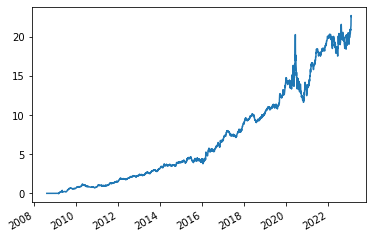

In [58]:
tmp_wts = backtest_tools.unconstrained_mvo(tmp_rets, tmp_rets.mean()/tmp_rets.std())
backtest_tools.cumulative_returns((tmp_rets * tmp_wts).sum(1)).plot()
backtest_tools.performance_summary((tmp_rets * tmp_wts).sum(1))
